In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from datasets import load_dataset

Loads the dataset and performs preprocessing, including mapping numeric labels to string categories and handling missing values.
    
Parameters:

    dataset_name (str): The dataset used for News Classification.
    
Returns:

    train_df (DataFrame): Preprocessed training data.

    test_df (DataFrame): Preprocessed testing data.

In [2]:
CATEGORY_MAPPING = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [3]:
def load_and_preprocess_data():
    dataset_name="fancyzhx/ag_news"
    dataset = load_dataset(dataset_name)
    
    train_data = dataset["train"]
    test_data = dataset["test"]
    
    train_df = train_data.to_pandas()
    test_df = test_data.to_pandas()
        
    train_df['Category'] = train_df['label'].map(CATEGORY_MAPPING)
    test_df['Category'] = test_df['label'].map(CATEGORY_MAPPING)
        
    return train_df, test_df

Builds a text classification pipeline with TF-IDF vectorizer and Decision Tree classifier.
    
Parameters:

    max_depth (int): Maximum depth of the decision tree.

    min_samples_split (int): Minimum number of samples required to split an internal node.

    ccp_alpha (float): Complexity parameter used for Minimal Cost-Complexity Pruning.
    
Returns:

    pipeline (Pipeline): A scikit-learn pipeline.

In [4]:
def build_pipeline(max_depth=10, min_samples_split=5, ccp_alpha=0.0):
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000)),
        ("clf", DecisionTreeClassifier(max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        ccp_alpha=ccp_alpha,
                                        random_state=42))
    ])
    return pipeline

Performs hyperparameter tuning using GridSearchCV.
    
Parameters:
    
    pipeline (Pipeline): The machine learning pipeline.
    
    X_train (list): Training text data.
    
    y_train (list): Training labels.

Returns:
    
    best_pipeline (Pipeline): Pipeline with the best found parameters.

In [5]:
def tune_hyperparameters(pipeline, X_train, y_train):
    param_grid = {
        "clf__max_depth": [10, 20, None],
        "clf__min_samples_split": [2, 5, 10],
        "clf__ccp_alpha": [0.0, 0.001, 0.01]
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best hyperparameters found:", grid_search.best_params_)
    return grid_search.best_estimator_

Plots the confusion matrix using Seaborn heatmap.

Parameters:

    y_true (list): True labels.

    y_pred (list): Predicted labels.

    labels (list): List of label names.

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

Main function to execute the news classification pipeline.


Best hyperparameters found: {'clf__ccp_alpha': 0.0, 'clf__max_depth': None, 'clf__min_samples_split': 2}
=== Test Set Performance ===
Accuracy: 0.7996052631578947
Classification Report:
               precision    recall  f1-score   support

    Business       0.77      0.74      0.76      1900
    Sci/Tech       0.77      0.76      0.76      1900
      Sports       0.85      0.87      0.86      1900
       World       0.81      0.82      0.81      1900

    accuracy                           0.80      7600
   macro avg       0.80      0.80      0.80      7600
weighted avg       0.80      0.80      0.80      7600

=== Cross-Validation on Training Set ===
CV Accuracy Scores: [0.79279167 0.79658333 0.799125   0.79333333 0.79058333]
Mean CV Accuracy: 0.7945 ± 0.0030


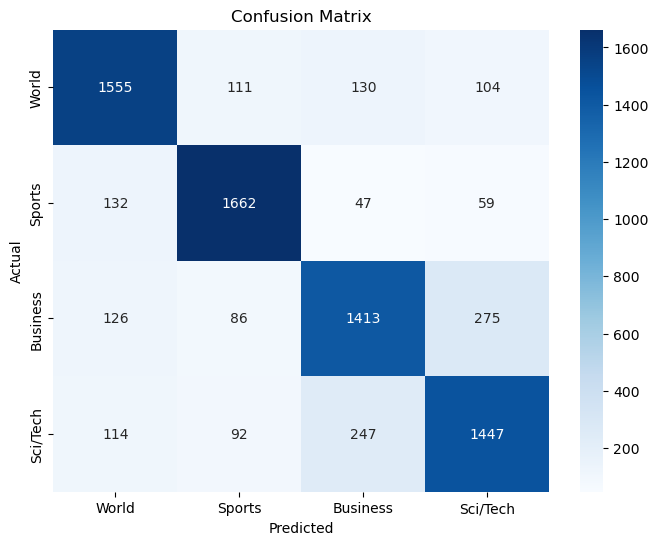

Top 10 important features:
iraq: 0.0296
stocks: 0.0230
microsoft: 0.0227
game: 0.0199
season: 0.0177
minister: 0.0169
president: 0.0157
oil: 0.0156
cup: 0.0155
killed: 0.0152
=== Usage Example ===
Text: Wall Street sees renewed optimism in tech stocks
Predicted Label: Business

Text: Soccer World Cup final brings excitement worldwide
Predicted Label: Sports



In [ ]:
train_df, test_df = load_and_preprocess_data()
X_train = train_df['text'].tolist()
y_train = train_df['Category'].tolist()
X_test = test_df['text'].tolist()
y_test = test_df['Category'].tolist()

pipeline = build_pipeline()
tuned_pipeline = tune_hyperparameters(pipeline, X_train, y_train)
tuned_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = tuned_pipeline.predict(X_test)
print("=== Test Set Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Cross-validation on the training set
print("=== Cross-Validation on Training Set ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(tuned_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Performance Analysis: Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=list(CATEGORY_MAPPING.values()))

# Usage Example: Predict new samples
new_samples = [
    "Wall Street sees renewed optimism in tech stocks",
    "Soccer World Cup final brings excitement worldwide"
]
predictions = tuned_pipeline.predict(new_samples)
print("=== Usage Example ===")
for text, pred in zip(new_samples, predictions):
    print(f"Text: {text}\nPredicted Label: {pred}\n")
    